# Gini

## Pre-processing

    import

In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# text processor(word tokenizer, lower, strip)
from modules.processing import free_form_processor

import re

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

    read

In [27]:
loans_clean = pd.read_csv("../data/transformed/loans_cleaned.csv")

In [28]:
loans_clean.head()

,LOAN_ID,DESCRIPTION,LOAN_AMOUNT,LOAN_USE,TAGS,FEMALE_OPERATED,ORIGINAL_LANGUAGE_Arabic,ORIGINAL_LANGUAGE_English,ORIGINAL_LANGUAGE_French,ORIGINAL_LANGUAGE_Indonesian,...,SECTOR_NAME_Entertainment,SECTOR_NAME_Food,SECTOR_NAME_Health,SECTOR_NAME_Housing,SECTOR_NAME_Manufacturing,SECTOR_NAME_Personal Use,SECTOR_NAME_Retail,SECTOR_NAME_Services,SECTOR_NAME_Transportation,SECTOR_NAME_Wholesale
0,1737446,Emelisa is 32 years old. With two children in...,125.0,"to buy items to sell like beverages, canned go...",#Woman-Owned Business,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1274681,Samol is married and she lives with her husban...,1000.0,to purchase construction material.,"#Repair Renew Replace, #Parent",1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1552694,Abla is an unmarried woman living in Agoe. She...,200.0,"to buy 5 sacks of corn, 2 cans of oil, and a s...","#Woman-Owned Business, user_favorite",1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,1756537,Emanuellita works hard to support six children...,100.0,to build a sanitary toilet,"#Health and Sanitation, #Eco-friendly",1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,343721,Leizel is 26 years old and married with one ch...,375.0,to buy livestock to raise,NaN,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


    downsample

In [29]:
downsampled_df = pd.DataFrame(loans_clean.sample(10000, replace=False, random_state=137))

    process

In [170]:
# grab set of stopwords from nltk and CV
sw = set(stopwords.words("english"))
cv = set(CountVectorizer(stop_words="english").get_stop_words())

# union of set extend with custom stopwords
stops = list(set(cv | sw))
stops.extend(["php", "kiva", "000", "br", "requesting", "order", "loans", "day", "used",
             "10", "earns", "nshe", "general", "members", "member", "requested", "pay", "loan",
             "buy", "sell", "sale", "sales", "year", "old", "like", "able", "nwtf", "use",
             "philippines", "years", "r", "n", "t"])

    tokenize

In [31]:
downsampled_df["PROCESSED_DESCRIPTION"] = free_form_processor(downsampled_df, "DESCRIPTION", stops)

In [32]:
downsampled_df["PROCESSED_DESCRIPTION"].head(10)

449544     ibtisam 41 married lady knits wool make clothi...
1514586    nemesiana married woman mother children reside...
1180890    chansamoul group lives rural village kampong s...
169050     salim 30 orphaned young age lost seven sibling...
2003240    cristina married children job working institut...
515448     karen 29 age married farmer blessed child mana...
1420834    ledubina amor esperanza love hope village bank...
1257437    married mother children celia works hard suppo...
1910062    marisol 23 single took precautions pregnant li...
39470      francis 38 operating van transport business ma...
Name: PROCESSED_DESCRIPTION, dtype: object

In [33]:
downsampled_df.drop(downsampled_df\
                    [downsampled_df["TAGS"].str.replace("#", "").str.split(", ").isnull()].index)\
                    ["TAGS"].str.replace("#", "").str.split(", ").apply(pd.Series).stack().value_counts()

user_favorite                     5047
Parent                            2248
Woman-Owned Business              2180
Repeat Borrower                   1246
Elderly                            876
Animals                            700
Eco-friendly                       648
Schooling                          640
Vegan                              532
Health and Sanitation              491
Biz Durable Asset                  469
Technology                         341
volunteer_pick                     321
Single Parent                      252
Supporting Family                  243
Fabrics                            241
First Loan                         218
Single                             215
Repair Renew Replace               211
volunteer_like                     179
Sustainable Ag                     164
Widowed                            135
Job Creator                        116
Trees                               84
Female Education                    71
Refugee                  

### n-grams

    unigrams

In [34]:
# Count vectorizer is instantiated
cv_uni = CountVectorizer(
    min_df = 0.0001,
    max_df = 0.90,
    ngram_range = (1,1),
    max_features = 1000
)

uni = cv_uni.fit_transform(downsampled_df["PROCESSED_DESCRIPTION"])
df_uni  = pd.DataFrame(uni.todense().astype(np.uint8), columns=cv_uni.get_feature_names_out())

cnt_df_uni = df_uni.sum().sort_values(ascending=False)
cnt_df_uni.to_csv("../data/transformed/description_unigrams.csv")

In [35]:
df_cnt_uni = pd.read_csv("../data/transformed/description_unigrams.csv", names=["unigram", "count"])
#df_cnt_uni[2:50]

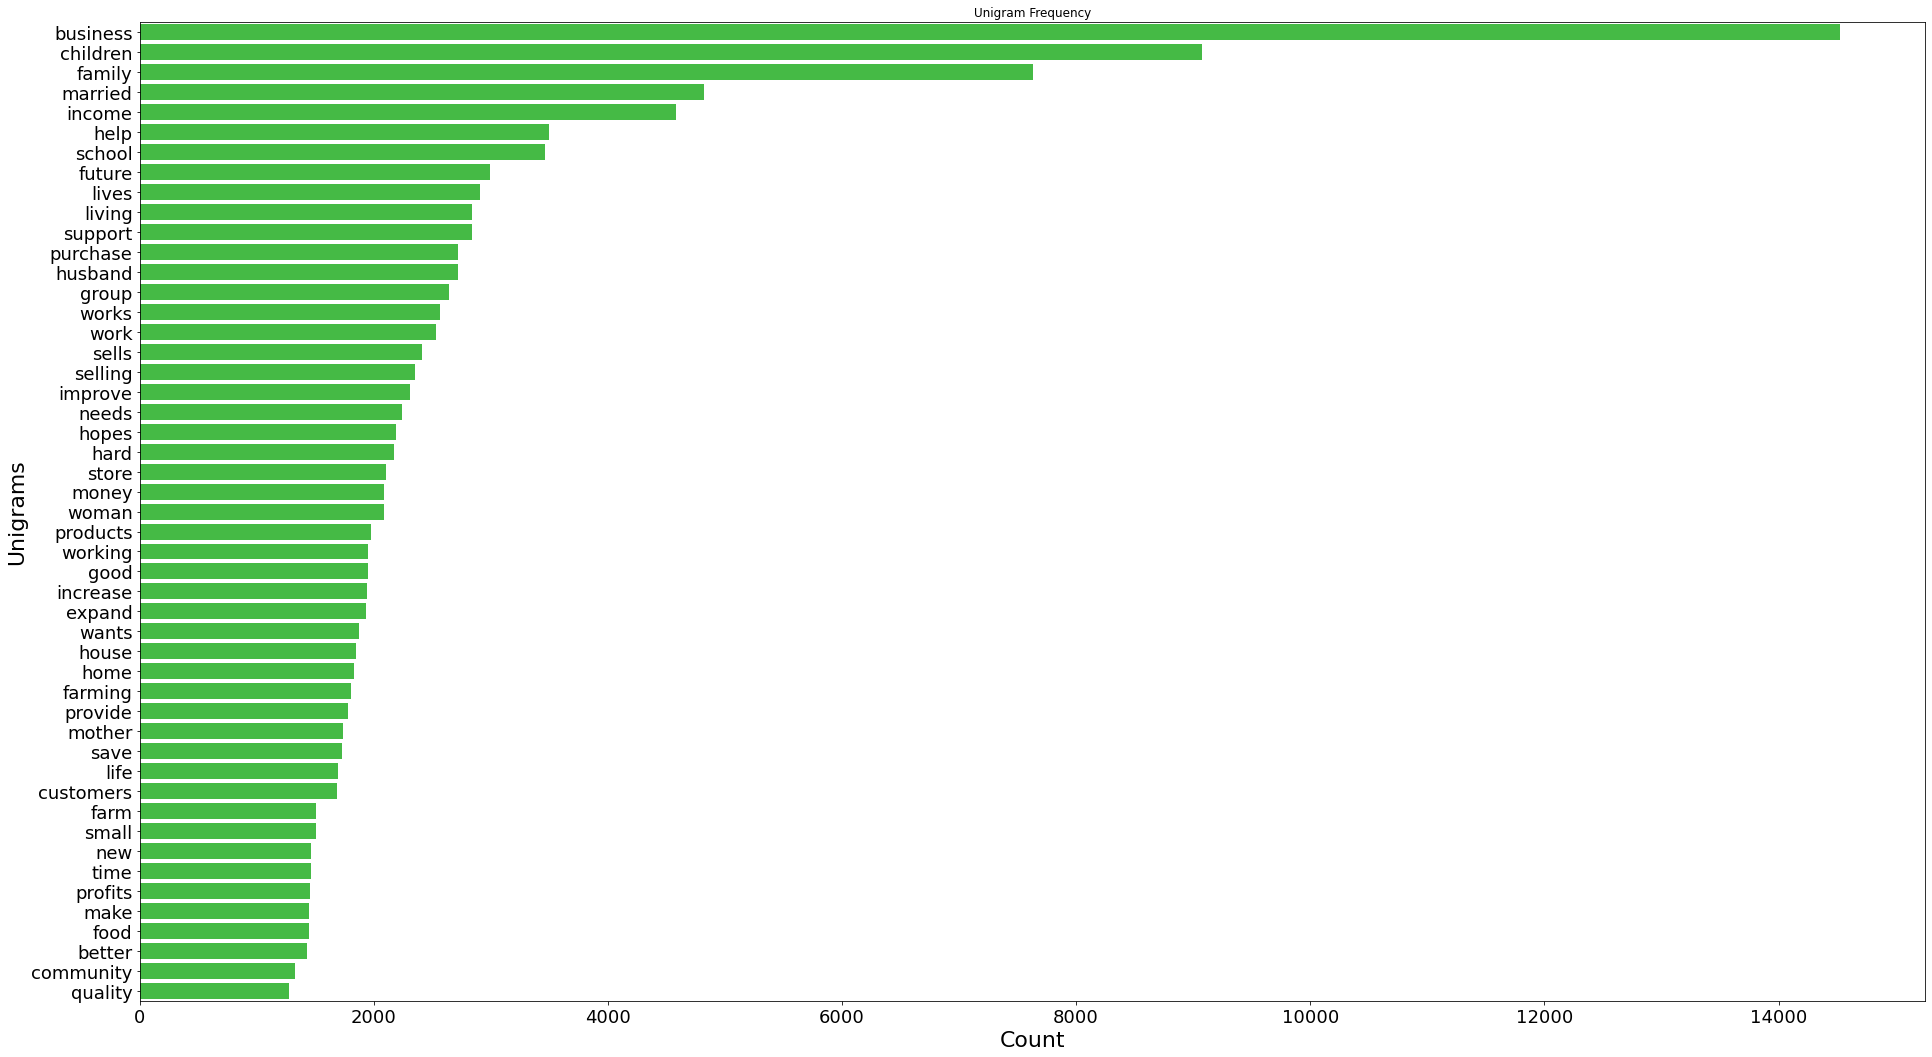

In [131]:
plt.figure(figsize=(32,18))

sns.barplot(data = df_cnt_uni[0:50], x = "count", y = "unigram", orient = "h", color="limegreen")

plt.title("Unigram Frequency")
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("Unigrams", fontsize=22)
plt.xlabel("Count", fontsize=22);

    bigrams

In [37]:
# Count vectorizer is instantiated
cv_bi = CountVectorizer(
    min_df = 0.0001,
    max_df = 1.0,
    ngram_range = (2,2),
    max_features= 1000
)

bi = cv_bi.fit_transform(downsampled_df["PROCESSED_DESCRIPTION"])
df_bi  = pd.DataFrame(bi.todense().astype(np.uint8), columns=cv_bi.get_feature_names_out())
cnt_df_bi = df_bi.sum().sort_values(ascending=False)
cnt_df_bi.to_csv("../data/transformed/description_bigrams.csv")

In [38]:
df_cnt_bi = pd.read_csv("../data/transformed/description_bigrams.csv", names=["bigram", "count"])
#df_cnt_bi[2:25]

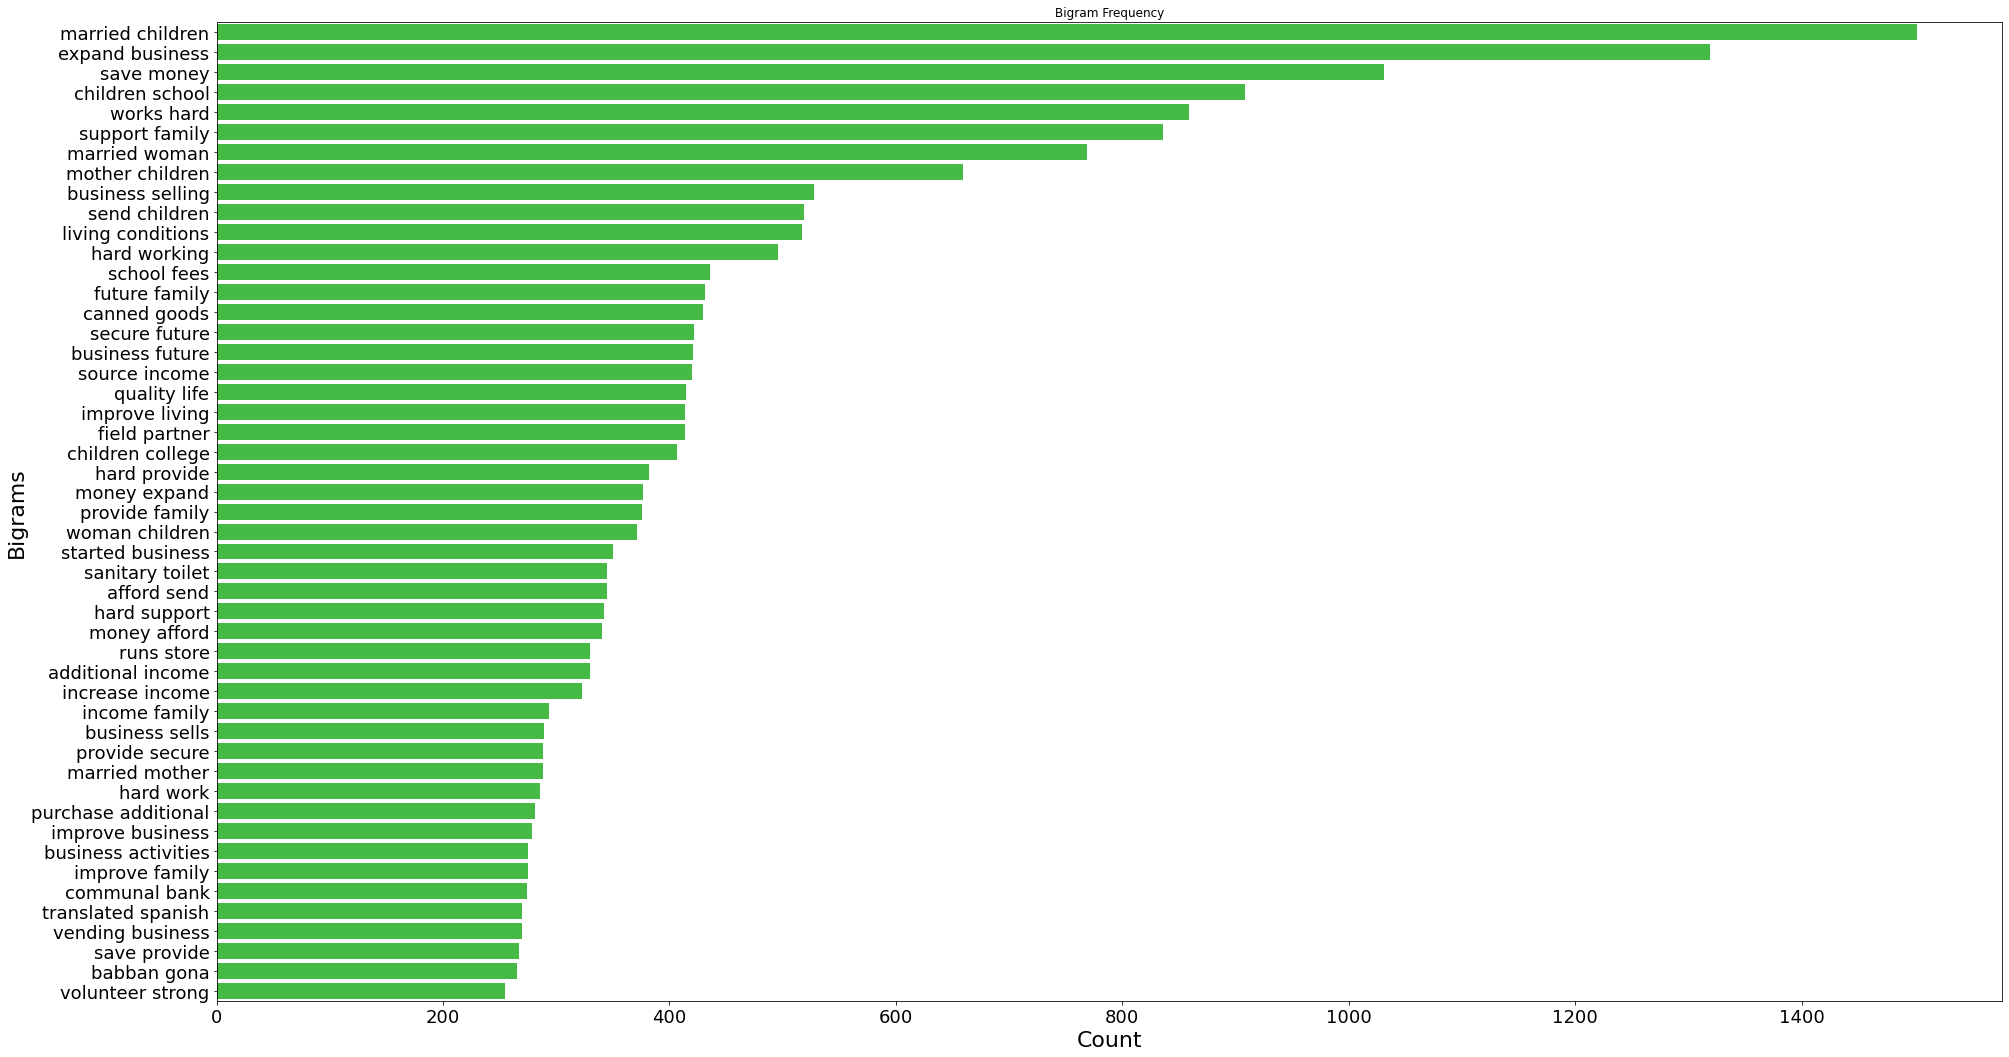

In [132]:
plt.figure(figsize=(32,18))

sns.barplot(data = df_cnt_bi[0:50], x = "count", y = "bigram", orient = "h", color="limegreen")

plt.title("Bigram Frequency")
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("Bigrams", fontsize=22)
plt.xlabel("Count", fontsize=22);

    trigrams

In [40]:
# Count vectorizer is instantiated
cv_tri = CountVectorizer(
    min_df = 0.0001,
    max_df = 1.0,
    ngram_range = (3,3),
    max_features= 1000
)

tri = cv_tri.fit_transform(downsampled_df["PROCESSED_DESCRIPTION"])
df_tri  = pd.DataFrame(tri.todense().astype(np.uint8), columns=cv_tri.get_feature_names_out())
cnt_df_tri = df_tri.sum().sort_values(ascending=False)
cnt_df_tri.to_csv("../data/transformed/description_trigrams.csv")

In [41]:
df_cnt_tri = pd.read_csv("../data/transformed/description_trigrams.csv", names=["trigram", "count"])
#df_cnt_tri[2:25]

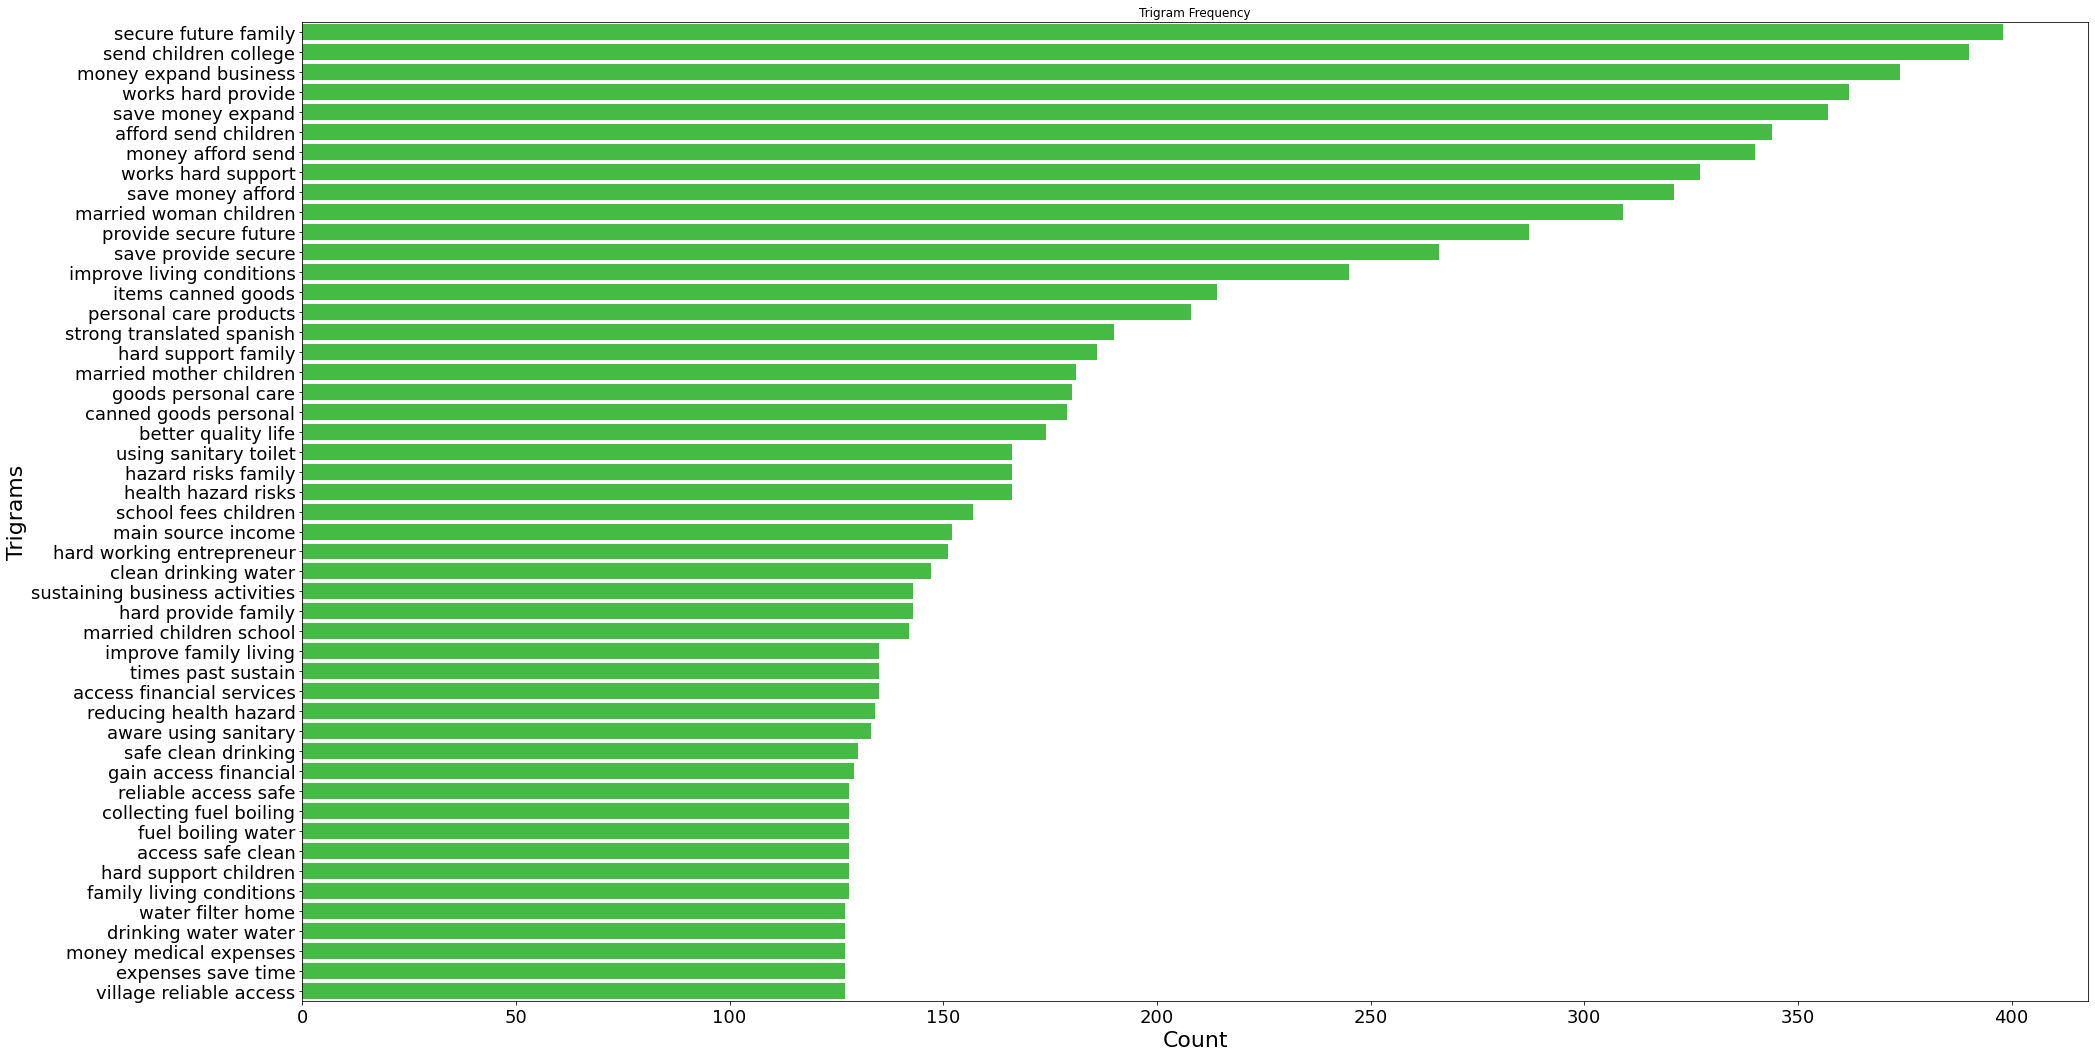

In [133]:
plt.figure(figsize=(32,18))

sns.barplot(data = df_cnt_tri[0:50], x = "count", y = "trigram", orient = "h", color="limegreen")

plt.title("Trigram Frequency")
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("Trigrams", fontsize=22)
plt.xlabel("Count", fontsize=22);

    4-grams

In [43]:
# Count vectorizer is instantiated
cv_quad = CountVectorizer(
    min_df = 0.0001,
    max_df = 1.0,
    ngram_range = (4,4),
    max_features= 1000
)

quad = cv_quad.fit_transform(downsampled_df["PROCESSED_DESCRIPTION"])
df_quad  = pd.DataFrame(quad.todense().astype(np.uint8), columns=cv_quad.get_feature_names_out())
cnt_df_quad = df_quad.sum().sort_values(ascending=False)
cnt_df_quad.to_csv("../data/transformed/description_4grams.csv")

In [44]:
df_cnt_4 = pd.read_csv("../data/transformed/description_4grams.csv", names=["4-gram", "count"])
#df_cnt_4[2:25]

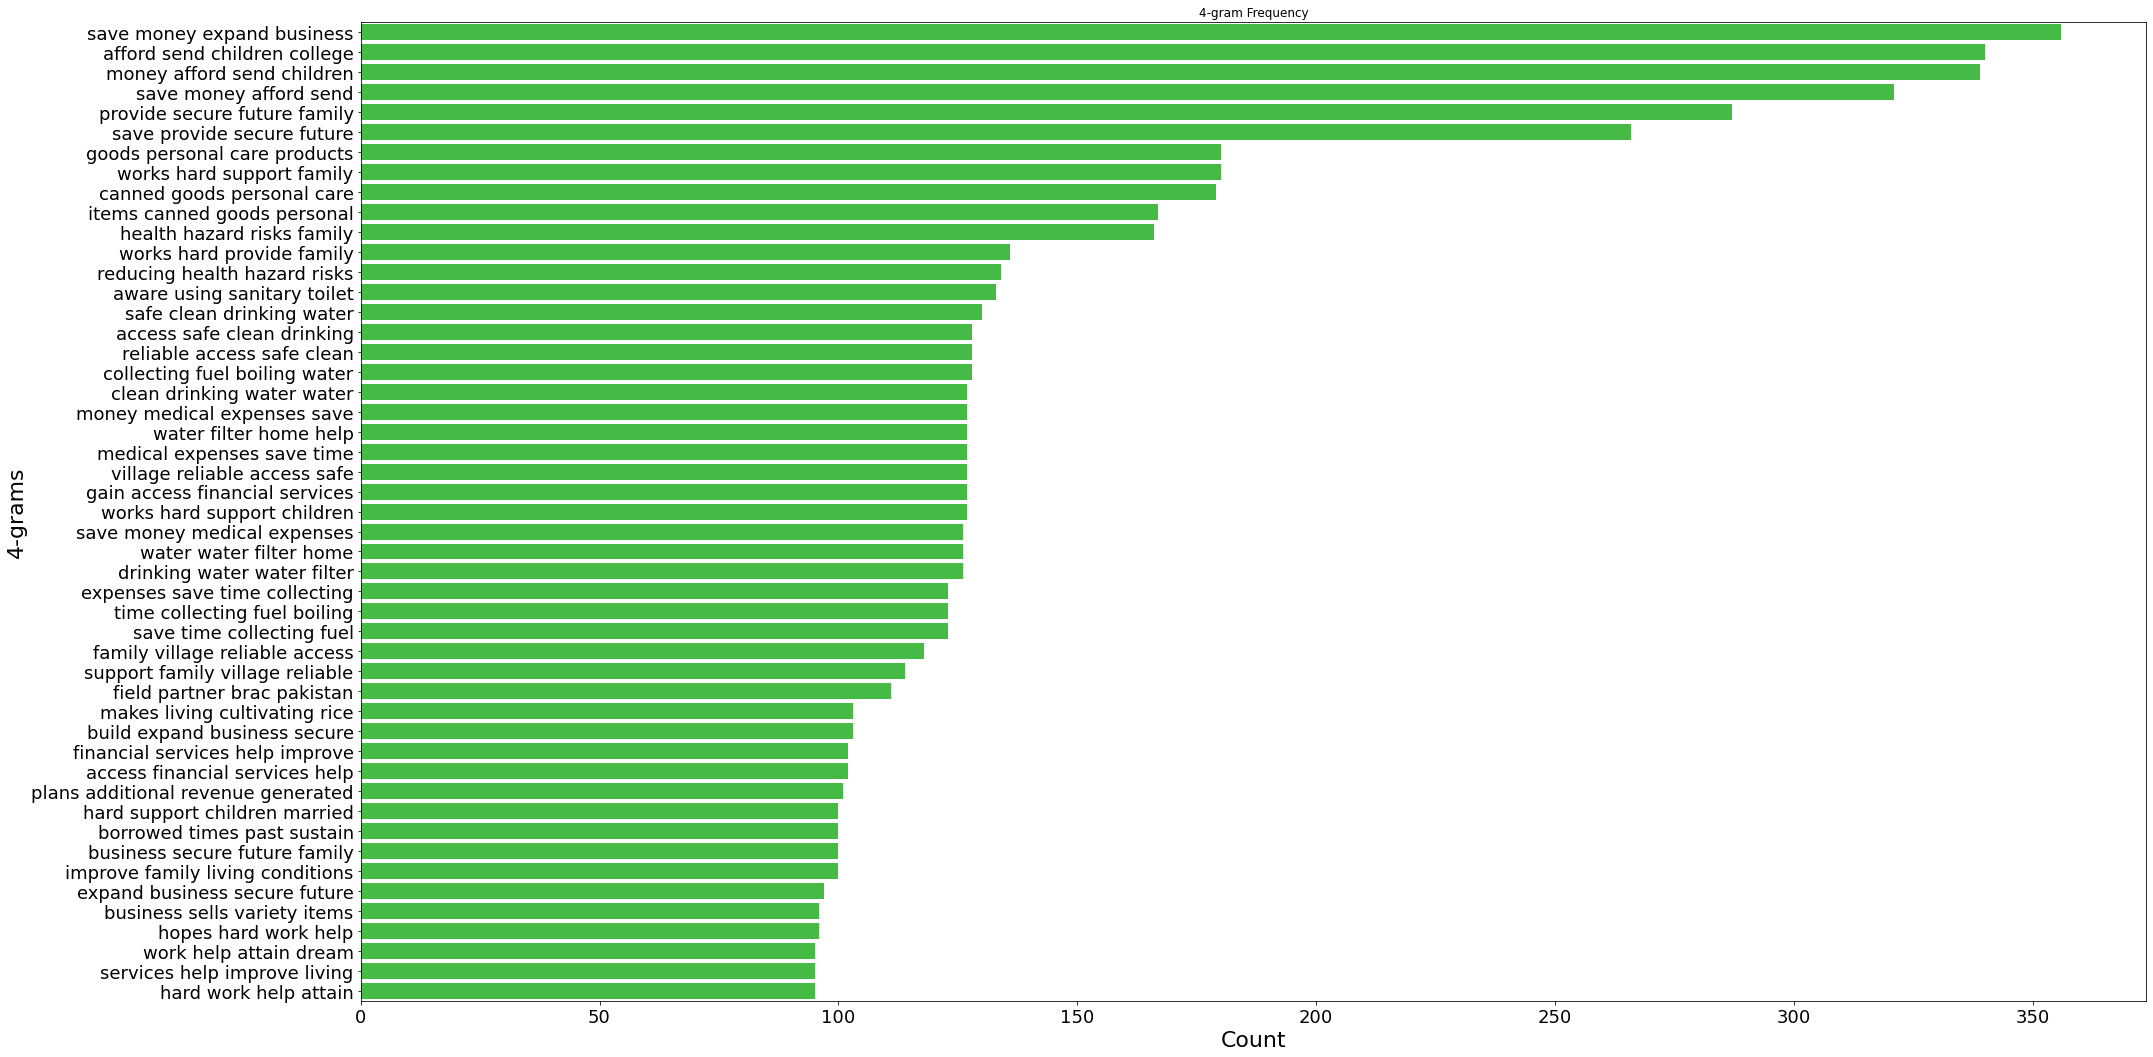

In [135]:
plt.figure(figsize=(32,18))

sns.barplot(data = df_cnt_4[0:50], x = "count", y = "4-gram", orient = "h", color="limegreen")

plt.title("4-gram Frequency")
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("4-grams", fontsize=22)
plt.xlabel("Count", fontsize=22);

    5-grams

In [46]:
# Count vectorizer is instantiated
cv_pent = CountVectorizer(
    min_df = 0.0001,
    max_df = 1.0,
    ngram_range = (5,5),
    max_features= 1000
)

pent = cv_pent.fit_transform(downsampled_df["PROCESSED_DESCRIPTION"])
df_pent  = pd.DataFrame(pent.todense().astype(np.uint8), columns=cv_pent.get_feature_names_out())
cnt_df_pent = df_pent.sum().sort_values(ascending=False)
cnt_df_pent.to_csv("../data/transformed/description_5grams.csv")

In [47]:
df_cnt_5 = pd.read_csv("../data/transformed/description_5grams.csv", names=["5-gram", "count"])
#df_cnt_5[2:25]

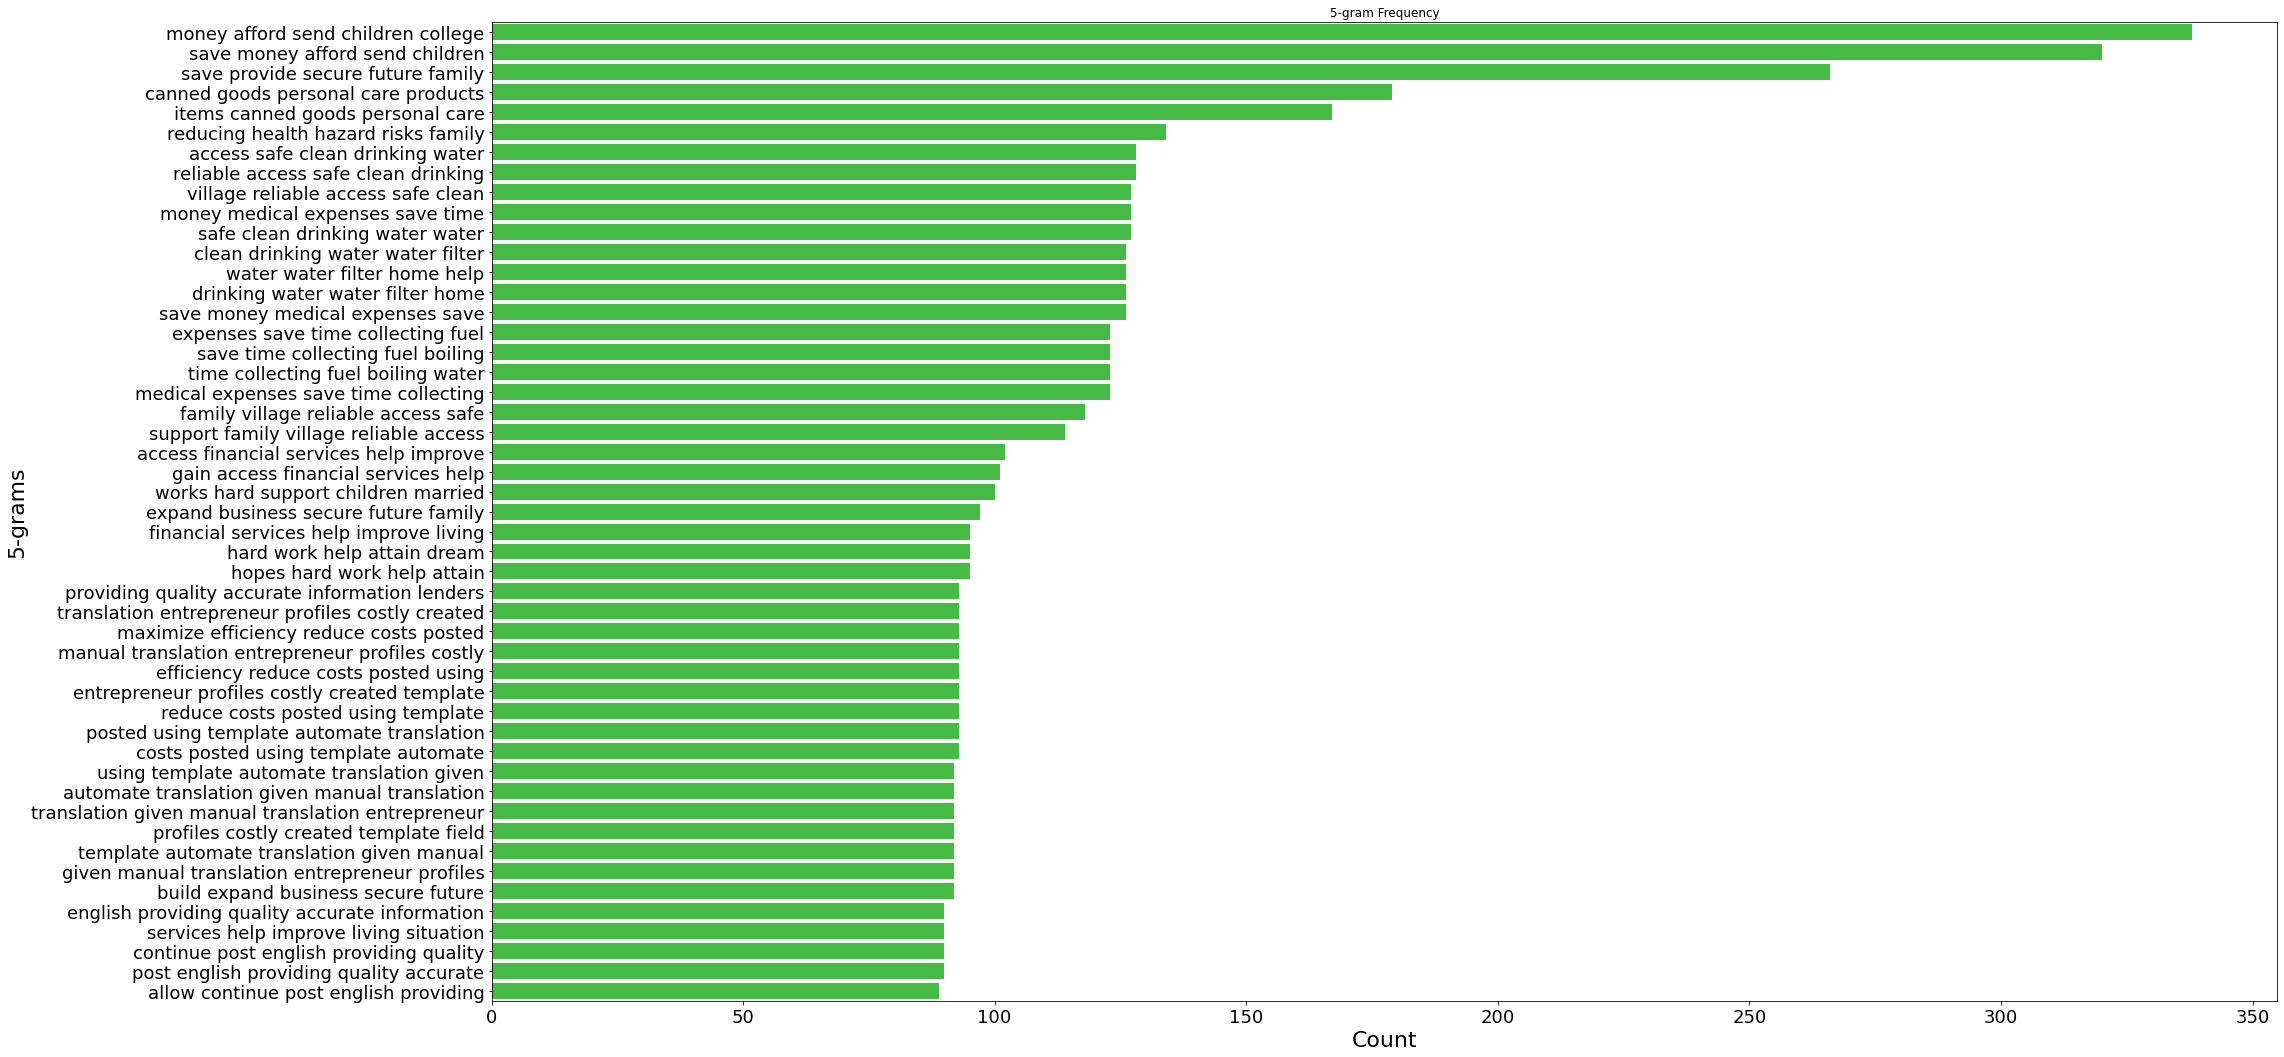

In [136]:
plt.figure(figsize=(32,18))

sns.barplot(data = df_cnt_5[0:50], x = "count", y = "5-gram", orient = "h", color="limegreen")

plt.title("5-gram Frequency")
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel("5-grams", fontsize=22)
plt.xlabel("Count", fontsize=22);

### Tags to Items

In [141]:
# only works for unigrams right now this might be sufficient.

ngrams                    = ["attend school", "drinking water", "dream", "children school", "farm",\
                             "married woman", "expand business", "covid 19", "hygiene", "single mother",\
                             "entrepeneur", "high school", "water filter", "medical expenses",
                             "cultivating", "fish vending", "school fees", "sanitary", "toilet"
                             "canned goods"]   #example manually selects ngram to add as tag

    # downsampled_df["TAGS+"]     = downsampled_df["TAGSsans#"] +\
    #                               downsampled_df["PROCESSED_DESCRIPTION"].map(lambda x: list(\
    #                               set([g for g in x.split() if g in unigrams]))) # find unigrams in
    #                                                                              # processed description
    # downsampled_df["TAGS+"]     = downsampled_df["TAGSsans#"] +\
    #                               downsampled_df["PROCESSED_DESCRIPTION"].map(lambda x: list(\
    #                               set([g for g in x if g in bigrams]))) # find bigrams in
    #                                                                     # processed description

    # downsampled_df["TAGS+"]     = downsampled_df["TAGSsans#"] +\
    #                               downsampled_df["PROCESSED_DESCRIPTION"].map(lambda x: list(\
    #                               re.findall('\b{bigrams}\b', x))) # find unigrams in
    #                                                                # processed description

    # downsampled_df["TAGS+"]     = downsampled_df["TAGS+"].map(lambda x: x[1:] if "" in x else x)

def tags_to_items(df, tags_column, text_column, ngrams):
    ngram_regex_expression      = "|".join(ngrams)

    df[tags_column].fillna("rancor", inplace = True) # NaNs do not allow list extension

    tags_sans_hash = df[tags_column].str.replace("#", "").str.split(", ") #removing #

    tags_plus      = tags_sans_hash +\
                            df[text_column].map(lambda x: list(\
                            set(re.findall(ngram_regex_expression, x)))) # find ngrams in
                                                                         # processed description 
    
    #tags_plus     = df[tags_column].map(lambda x: x.pop(0) if x[0] == "rancor" else x)
    
    return tags_plus

In [178]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.
# LabelBinarizer.html#sklearn.preprocessing.LabelBinarizer

# Demonstrated with TAGS, to be changed to TAGS+

mlb = MultiLabelBinarizer(sparse_output=True)

# preprocessed_df = pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(downsampled_df.drop(downsampled_df\
#                     [downsampled_df["TAGS+"].str.replace("#", "").str.split(", ").isnull()].index)\
#                     ["TAGS+"].str.replace("#", "").str.split(", ")),
#                     columns = mlb.classes_)

preprocessed_df = pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(
                  downsampled_df["TAGS+"]),
                  columns = mlb.classes_)

In [179]:
preprocessed_df

,Animals,Biz Durable Asset,Eco-friendly,Elderly,Fabrics,Female Education,First Loan,Health and Sanitation,Hidden Gem,Inspiring Story,...,married woman,medical expenses,rancor,sanitary,school fees,single mother,user_favorite,volunteer_like,volunteer_pick,water filter
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


### Content Filter Preprocessing Pipeline

In [195]:
def pipeline_content_filter(df, text_columns, tags_column, stops, ngrams):
    """
    
    """
    df["TEXT"] = ""
    
    for col in text_columns:
        df["TEXT"] += df[col]
    
    # process text
    df["PROCESSED_TEXT"] = free_form_processor(df, "TEXT", stops)
    
    # 
    df["TAGS+"]          = tags_to_items(df, "TAGS", "PROCESSED_TEXT", ngrams)
        
    # 
    mlb = MultiLabelBinarizer(sparse_output=True)
    
    binarized_items_df   = pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(
                           df["TAGS+"]), columns = mlb.classes_)
    
    df.reset_index(inplace=True, drop=True)
    
    return df.join(binarized_items_df)

    downsample

In [198]:
content_filter_df = pd.DataFrame(loans_clean.sample(10000, replace=False, random_state=137))

    pipeline

In [199]:
content_filter_processed = content_filter_pipeline(content_filter_df, ["DESCRIPTION", "LOAN_USE"], "TAGS", stops, ngrams)

    export

In [200]:
#df.reset_index(inplace=True, drop=True)
#df_clean.to_csv("../data/transformed/preprocessed_df_data.csv", index = False)

content_filter_processed.reset_index(inplace=True, drop=True)
content_filter_processed.to_csv("../data/transformed/processed_content_filter_data.csv", index = False)